In [3]:
%matplotlib inline
import os
import csv
import fnmatch
import numpy as np
import datetime
import re
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd


In [4]:
def CharactersTyped(ScratchPad):
    
    NotInclude = ['scratchPadText', '']
    PhraseTypedAll = [item[1] for item in scratchPad]

    IndexNotInclude = [itemInd for itemInd in range(0,len(PhraseTypedAll)) if PhraseTypedAll[itemInd] == '']

    PhrasesTypedEnd = [PhraseTypedAll[item-1] for item in IndexNotInclude if item != 1]

    return len(''.join(PhrasesTypedEnd))

In [5]:
def ComputeDwellTime(TimeDwellChanges, TimeDwellOrig):
    # We need the dwell time and when it changes (index)
    
    TimeDwellNew = TimeDwellOrig
    #TimeDwellChanges = [key for key in userKeys if key[1] in KeyInclude]
    TimeDwellChangeInfo= list()
    pctChangeIndList = list()
    TimeDwellNewList = [TimeDwellOrig]
    #print(TimeDwellChanges)
    indPrev = 0
    flagFirst = 0
    
    for pctChangeInd in range(0, len(TimeDwellChanges)):
        
        if 'DwellTime' in TimeDwellChanges[pctChangeInd][1]:
            
            if float(TimeDwellChanges[pctChangeInd][2]) == 1:
                if 'Increase' in TimeDwellChanges[pctChangeInd][1]:
                    TimeDwellNew = TimeDwellNew + 100
                    TimeDwellNewList.append(TimeDwellNew)
                    pctChangeIndList.append(pctChangeInd)        
                    
                else:
                    TimeDwellNew = TimeDwellNew - 100
                    TimeDwellNewList.append(TimeDwellNew)
                    pctChangeIndList.append(pctChangeInd)
                        
        
        if pctChangeInd == len(TimeDwellChanges)-1:
            pctChangeIndList.append(pctChangeInd)
    
    return [pctChangeIndList]+[TimeDwellNewList]

In [6]:
def TimeOnScratchPad(UserLooksAtKey, TimeDwellChanges):
    
    ScratchPadLookedInd = [ind for ind in range(0,len(UserLooksAtKey)) if 'ScratchPad' in UserLooksAtKey[ind]]
    ScratchPadRow = [UserLooksAtKey[ind] for ind in range(0,len(UserLooksAtKey)) if 'ScratchPad' in UserLooksAtKey[ind]]
    ScratchPadIndDiff = np.diff(np.asarray(ScratchPadLookedInd))

    timeOfLooking = 0
    flagStart = 0
    TimeDwellScratchPad = 0
    ScratchPadInd = 0
    TimeDwellNow = 0
    
    for ind1 in range(0, len(ScratchPadIndDiff)):
        if ScratchPadIndDiff[ind1] != 1:
            # check if it is the same fixation
            
            if ScratchPadRow[ind1 - 1][2] > ScratchPadRow[ind1][2]:
                
                ScratchPadInd = ind1
                # find correct dwell time
                for dwellTimeInd in range(0, len(TimeDwellChanges[0])):
                    if TimeDwellChanges[0][dwellTimeInd] > ScratchPadLookedInd[ind1]:
                        TimeDwellNow = TimeDwellChanges[1][dwellTimeInd]
                        break
                
                if TimeDwellNow == 0:
                    TimeDwellNow = TimeDwellChanges[1][0]
                TimeDwellScratchPad = TimeDwellScratchPad + TimeDwellNow*float(ScratchPadRow[ind1-1][2])
    
    for dwellTimeInd in range(0, len(TimeDwellChanges[0])):
        
        if ScratchPadInd > ScratchPadLookedInd[ind1]:
            TimeDwellNow = TimeDwellChanges[1][dwellTimeInd]
            break
    if TimeDwellNow == 0:
        TimeDwellNow = TimeDwellChanges[1][0]
    
    TimeDwellScratchPad = TimeDwellScratchPad + TimeDwellNow*float(ScratchPadRow[-2][2])        
                    
    return TimeDwellScratchPad
        

In [7]:
metricComputed = 'read_text_events_time_ratio'
subjName = r'C:\DTU\Data\201805_HealthnRehab\TypingData'
Names = list()
ScratchPadToTypingRatio = list()
nCount = 0

for root, dirs, subfolder in os.walk(subjName):
    scratchPad = None
    userKeys = None
    freqScratchPad = 0
    if not dirs:
        
        if 'notCompleted' in root or 'notInclude' in root:
            continue
        if 'tb' in root or 'joha' in root:
            continue

        for file in subfolder:
            
            if fnmatch.fnmatch(file, 'user*'):
                try:
                    
                    fUserKey = open(root + '\\' + file, encoding='utf-8')
                    readerUserKey = csv.reader(fUserKey)
                    userKeys = list(readerUserKey)
                    userKeys.remove(userKeys[0])
                except:
                    if fUserKey is not None:
                        fUserKey.close()
                    else:
                        print('error in opening the scratchpad log file')
                    
                        
            elif fnmatch.fnmatch(file, 'ScratchPadLog*'):

                try:
                    
                    fScratchPad = open(root + '\\' + file, encoding='utf-8')
                    readerScratchPad = csv.reader(fScratchPad)
                    scratchPad = list(readerScratchPad)
                    scratchPad.remove(scratchPad[0])
                except:
                    if fScratchPad is not None:
                        fScratchPad.close()
                    else:
                        print('error in opening the scratchpad log file')
                    
            else:
                continue
            
            if scratchPad and userKeys:
                TimeDwellOrig = 800
                
                # Dwell time and when it changes
                DwellTimeInfo = ComputeDwellTime(userKeys, TimeDwellOrig)
                #print(DwellTimeInfo)

                # Number of times scratchpad was looked at
                TimeLookedAtScratchPad = TimeOnScratchPad(userKeys, DwellTimeInfo)
                
                TimeLookedAtScratchPadInS = str(TimeLookedAtScratchPad/1000)
                a = re.compile('[0-9].[0-9]{6}')
                TimeLookedAtScratchPadWithFormat = a.findall(TimeLookedAtScratchPadInS)[0]
                print(TimeLookedAtScratchPadWithFormat)
                
                # Total time spent on typingheadStartPhrase,sep,tail = your_list[startPhrase+1][0].partition('+')
                headStartTyping, sep, tail = userKeys[0][0].partition('+')
                headStopTyping, sep, tail = userKeys[-1][0].partition('+')
                
                
                timeScratchPad = datetime.datetime.strptime(TimeLookedAtScratchPadWithFormat, "%S.%f") - datetime.datetime.strptime("1900-01-01 00:00:00", "%Y-%m-%d %H:%M:%S")
                timeTyping = datetime.datetime.strptime(re.sub('[:.T]','-',headStopTyping[:-1]), "%Y-%m-%d-%H-%M-%S-%f") - datetime.datetime.strptime(re.sub('[:.T]','-',headStartTyping[:-1]), "%Y-%m-%d-%H-%M-%S-%f")
                
                # save only the name of the subject and the date part of the file
                a = re.compile('(?<=TypingData)(.*)(?=OptiKey)')
                
                Names.append(a.findall(root)[0])
                ScratchPadToTypingRatio.append(float(timeScratchPad/timeTyping))
                
                nCount = nCount + 1
                break
                
if ScratchPadToTypingRatio:
    AddDataToFile(metricComputed, Names, ScratchPadToTypingRatio)

5.578163
0.484886
1.558330
2.631284
1.108736
1.414871
1.079994
1.660303
2.804748
1.179996
0.514580
4.109239
1.992835
5.157441
2.195201
2.160297
3.019256
0.452782
5.486490
2.348518
1.405031
3.677277
3.136254
2.487966
C:\DTU\Data\201805_HealthnRehab\data_summary.csv
w
This metric is already calculated and saved read_text_events_time_ratio


(array([5., 3., 6., 4., 2., 0., 2., 0., 0., 2.]),
 array([0.00148203, 0.00352813, 0.00557423, 0.00762034, 0.00966644,
        0.01171254, 0.01375864, 0.01580475, 0.01785085, 0.01989695,
        0.02194306]),
 <a list of 10 Patch objects>)

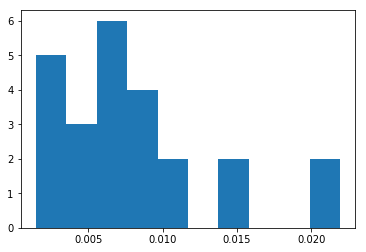

In [8]:
# Histogram of the ratio
plt.hist(ScratchPadToTypingRatio)


In [9]:
def AddDataToFile(metricComputed, Names, DataEvaluated):

    # Save the data
    fileIn = r'C:\DTU\Data\201805_HealthnRehab\data_summary.csv'

    if Path(fileIn).is_file():
        print(fileIn)
        fSize = os.path.getsize(fileIn) # or pd.read_excel(filename) for xls file

        # file exists
        # check if the given column exists
        with open(fileIn, 'r', newline='') as csvfileRead:
            if fSize > 0:
                fileOut = fileIn[:-4] + '1.csv'
                with open(fileOut, 'w', newline='') as csvfileWrite:
                    print('w')
                    for row in csv.reader(csvfileRead):
                        if metricComputed in row:
                    
                            print('This metric is already calculated and saved: ', metricComputed)
                            break
                        else:
                            print('adding the metric')
                            filewriter = csv.writer(csvfileWrite, delimiter = ',')
                            if row[0] == 'subject_name':
                                filewriter.writerow([row[0], metricComputed])
                            else:
                            
                                filewriter.writerow([row[0], str(DataEvaluated[Names.index(row[0])])])
            else:
                fileOut = fileIn
                print('recreating a file')

                with open(fileSave, 'w', newline='') as csvfileWrite:
                    filewriter = csv.writer(csvfileWrite, delimiter=',')
                    filewriter.writerow(['subject_name', metricComputed])
                    for ind in enumerate(Names):
                        filewriter.writerow([Names[ind], DataEvaluated[ind[0]]])
                
    else:
        print('creating a file')
        a = re.compile('(?<=TypingData)(.*)(?=OptiKey)')
        with open(fileSave, 'w', newline='') as csvfileWrite:
            filewriter = csv.writer(csvfileWrite, delimiter=',')
            filewriter.writerow(['subject_name', metricComputed])
            for ind in enumerate(Names):
                subjName = a.findall(Names[ind[0]])
                filewriter.writerow([subjName[0], DataEvaluated[ind[0]]])
    

In [ ]:
# userKeys = None
# scratchPad = None

# freqScratchPad = 0

# folder = r'C:\DTU\Data\201805_HealthnRehab\TypingData\May16\hc_MS\OptiKeyLogs\2018-5-16-13-42-4'
# for file in os.listdir(folder):

#     if fnmatch.fnmatchcase(file, 'user_looks_at_key*'):
#         try:
#             fUserKey = open(folder + '\\' + file, encoding='utf-8')
#             readerUserKey = csv.reader(fUserKey)
#             userKeys = list(readerUserKey)
#             userKeys.remove(userKeys[0])
                    
#         except:
#             if fUserKey is not None:
#                 fUserKey.close()
#             else:
#                 print('error in opening the user looks at file')
                        
#     elif fnmatch.fnmatch(file, 'ScratchPadLog*'):
#         try:                
#             fScratchPad = open(folder + '\\' + file, encoding='utf-8')
#             readerScratchPad = csv.reader(fScratchPad)
#             scratchPad = list(readerScratchPad)
#             scratchPad.remove(scratchPad[0])
#         except:
#             if fScratchPad is not None:
#                 fScratchPad.close()
#             else:
#                 print('error in opening the scratchpad log file')
                
#     else:
#         continue
    
#     # if all these lists exist:
#     if scratchPad and userKeys:

#         # Number of times scratchpad was looked at
        
#         freqScratchPad = UniqueGazeFreq(userKeys)
        
#         # Number of characters typed -- only the last phrase to be considered
#         nCharTyped = CharactersTyped(scratchPad)
        
#         nReadTextEventsPerChar = float(freqScratchPad/nCharTyped)
        
#         print(nReadTextEventsPerChar)

#         break
    